# FunGuts

## Importing packages

In [1]:
# Importing all required packages at the start of the notebook
import IPython

from qiime2 import Visualization

import qiime2 as q2
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## Download the data

In [2]:
# Location of the projects data
data_dir = 'projectData'

In [3]:
%%bash -s $data_dir
mkdir -p "$1"

wget -nc --progress=dot:giga -P "$1" https://polybox.ethz.ch/index.php/s/uV06vmm96ZzB5eM/download/fungut_forward_reads.qza
wget -nc --progress=dot:giga -P "$1" https://polybox.ethz.ch/index.php/s/CA76kKFC9FApqpR/download/fungut_metadata.tsv

chmod -R +rxw "$1"

File ‘projectData/fungut_forward_reads.qza’ already there; not retrieving.

File ‘projectData/fungut_metadata.tsv’ already there; not retrieving.



## Overview of the meta data

In [4]:
# Read data
df_meta = pd.read_csv('Submission_FunGut_script/Project_data/Metadata/updated_fungut_metadata.tsv', sep='\t')
df_meta

,ID,country_sample,state_sample,latitude_sample,longitude_sample,sex_sample,age_years_sample,height_cm_sample,weight_kg_sample,bmi_sample,diet_type_sample,ibd_sample,gluten_sample,age_range,bmi_category,continent
0,ERR5327198,USA,TN,36.1,-86.8,female,67.0,152.0,41.0,17.75,Omnivore,No IBD,No CD,62-72,Underweight,North America
1,ERR5327199,USA,DC,38.9,-77.1,male,55.0,182.0,79.0,23.73,Omnivore,No IBD,No CD / Gluten allergy,52-62,Healthy weight,North America
2,ERR5327266,USA,VA,38.9,-77.1,female,28.0,175.0,61.0,19.94,Omnivore,No IBD,No CD / Doesn't eat gluten,22-32,Healthy weight,North America
3,ERR5327282,United Kingdom,NaN,51.6,-0.2,female,26.0,166.0,60.0,21.77,Omnivore,No IBD,No CD,22-32,Healthy weight,Europe
4,ERR5327284,United Kingdom,NaN,51.5,-0.2,female,25.0,173.0,59.0,20.01,Vegetarian but eat seafood,No IBD,No CD,22-32,Healthy weight,Europe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,ERR5327599,Isle of Man,NaN,54.2,-4.7,female,58.0,172.0,65.0,21.97,Omnivore,No IBD,No CD,52-62,Healthy weight,Europe
146,ERR5327604,United Kingdom,NaN,51.4,-0.4,female,64.0,157.0,60.0,24.19,Omnivore but do not eat red meat,No IBD,No CD,62-72,Healthy weight,Europe
147,ERR5327605,United Kingdom,NaN,52.8,-1.3,male,80.0,175.0,73.0,23.77,Vegetarian,No IBD,No CD,72-82,Healthy weight,Europe
148,ERR5327615,United Kingdom,NaN,51.8,-1.3,female,53.0,176.0,64.0,20.66,Omnivore,No IBD,No CD,52-62,Healthy weight,Europe


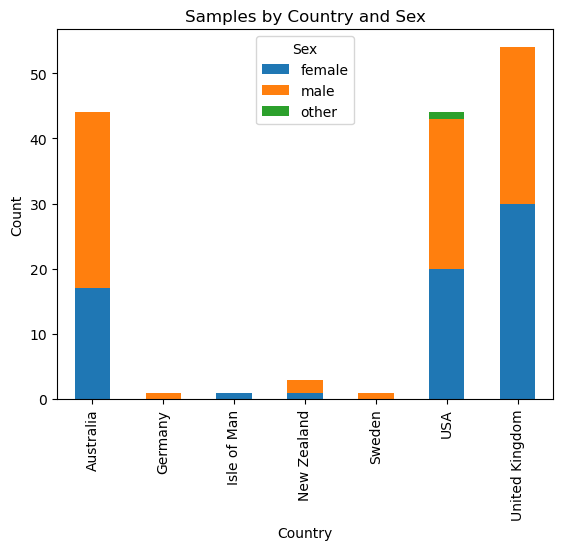

In [5]:
# Plotting some meta data
df_countrySex = df_meta[['country_sample', 'sex_sample']].value_counts().reset_index(name='count')
df_countrySexPivot = df_countrySex.pivot(index='country_sample', columns='sex_sample', values='count').fillna(0)

df_countrySexPivot.plot(kind='bar', stacked=True)
plt.title('Samples by Country and Sex')
plt.xlabel('Country')
plt.ylabel('Count')
plt.legend(title='Sex')
plt.show()

## Sequence import

In [11]:
# Examine at data
! qiime tools peek $data_dir/fungut_forward_reads.qza

UUID:        3638611d-1767-413b-9390-70ee3d78e4ff
Type:        SampleData[SequencesWithQuality]
Data format: SingleLanePerSampleSingleEndFastqDirFmt


In [12]:
# Visual summary of the data
! qiime demux summarize \
    --i-data $data_dir/fungut_forward_reads.qza \
    --o-visualization $data_dir/fungut_forward_reads_demux_seqs.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: projectData/fungut_forward_reads_demux_seqs.qzv


In [13]:
Visualization.load(f"{data_dir}/fungut_forward_reads_demux_seqs.qzv")

<visualization: Visualization uuid: 62965f5d-e444-4c50-81e6-c54fa0555b6f>

Notes from visualization:
- Really good quality, no trimming needed? -> Last three position a median quality score of 151:38, 150:38, 149:37

## Denoising - Amplicon Sequence Variants

In [14]:
! qiime dada2 denoise-single \
    --i-demultiplexed-seqs $data_dir/fungut_forward_reads.qza \
    --p-trunc-len 140 \
    --p-n-threads 3 \
    --p-max-ee 4 \
    --p-min-fold-parent-over-abundance 4 \
    --o-table $data_dir/dada2_table.qza \
    --o-representative-sequences $data_dir/dada2_rep_set.qza \
    --o-denoising-stats $data_dir/dada2_stats.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureTable[Frequency] to: projectData/dada2_table.qza
Saved FeatureData[Sequence] to: projectData/dada2_rep_set.qza
Saved SampleData[DADA2Stats] to: projectData/dada2_stats.qza


In [15]:
# Inspect the denoising stats
! qiime metadata tabulate \
    --m-input-file $data_dir/dada2_stats.qza \
    --o-visualization $data_dir/dada2_stats.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: projectData/dada2_stats.qzv


In [16]:
Visualization.load(f"{data_dir}/dada2_stats.qzv")

<visualization: Visualization uuid: 1d5a1cda-cd68-443a-a9f3-0b03b50ac57f>

In [17]:
# Create a feature table
! qiime feature-table tabulate-seqs \
    --i-data $data_dir/dada2_rep_set.qza \
    --o-visualization $data_dir/dada2_rep_set.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: projectData/dada2_rep_set.qzv


In [18]:
Visualization.load(f"{data_dir}/dada2_rep_set.qzv")

<visualization: Visualization uuid: a498ec4d-1ccf-447a-8033-e56ba7e49d41>

In [76]:
! qiime feature-table summarize-plus \
    --i-table $data_dir/dada2_table.qza \
    --m-metadata-file $data_dir/fungut_metadata.tsv \
    --o-summary $data_dir/dada2_table.qzv \
    --o-sample-frequencies $data_dir/sample-frequencies.qza \
    --o-feature-frequencies $data_dir/asv-frequencies.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved ImmutableMetadata to: projectData/asv-frequencies.qza
Saved ImmutableMetadata to: projectData/sample-frequencies.qza
Saved Visualization to: projectData/dada2_table.qzv


In [6]:
Visualization.load(f"{data_dir}/dada2_table.qzv")

<visualization: Visualization uuid: bd2d40d3-99a4-412e-995f-8b19bc889ec1>

## Taxonomy assignment

### Reference database construction  
Using the tutorial from W5 ([link](https://forum.qiime2.org/t/how-to-train-a-unite-classifier-using-rescript/28285?u=nicholas_bokulich)) for ITS regions  

Download and prepare the UNITE data

In [21]:
! [ -d "{data_dir}/uniteDB" ] || qiime rescript get-unite-data \
  --p-version '2025-02-19' \
  --p-taxon-group eukaryotes \
  --p-cluster-id 99 \
  --p-no-singletons \
  --verbose \
  --output-dir "{data_dir}/uniteDB"

Filter out unwanted placeholder taxa

In [22]:
! qiime rescript filter-seqs-length \
    --i-sequences $data_dir/uniteDB/sequences.qza \
    --p-global-min 100 \
    --o-filtered-seqs $data_dir/uniteDB/sequences-filtered.qza \
    --o-discarded-seqs $data_dir/uniteDB/sequences-discarded.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureData[Sequence] to: projectData/uniteDB/sequences-filtered.qza
Saved FeatureData[Sequence] to: projectData/uniteDB/sequences-discarded.qza


Edit taxonomy to remove SH codes

In [23]:
! qiime rescript edit-taxonomy \
    --i-taxonomy $data_dir/uniteDB/taxonomy.qza \
    --o-edited-taxonomy $data_dir/uniteDB/taxonomy-no-SH.qza \
    --p-search-strings ';sh__.*' \
    --p-replacement-strings '' \
    --p-use-regex

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureData[Taxonomy] to: projectData/uniteDB/taxonomy-no-SH.qza


Extract ITS1 region form the UNITE reference sequences.  
Primers used: f-primer ITS1F (CTTGGTCATTTAGAGGAAGTAA), r-primer ITS2 (GCTGCGTTCTTCATCGATGC)

In [24]:
! qiime feature-classifier extract-reads \
  --i-sequences $data_dir/uniteDB/sequences-filtered.qza \
  --p-f-primer 'CTTGGTCATTTAGAGGAAGTAA' \
  --p-r-primer 'GCTGCGTTCTTCATCGATGC' \
  --p-trunc-len 140 \
  --o-reads $data_dir/uniteDB/sequences-eukaryote-ITS1.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureData[Sequence] to: projectData/uniteDB/sequences-eukaryote-ITS1.qza


Dereplicate / collapse identical sequences

In [25]:
! qiime rescript dereplicate \
  --i-sequences $data_dir/uniteDB/sequences-eukaryote-ITS1.qza \
  --i-taxa $data_dir/uniteDB/taxonomy-no-SH.qza \
  --o-dereplicated-sequences $data_dir/uniteDB/derep-seqs-ITS1.qza \
  --o-dereplicated-taxa $data_dir/uniteDB/derep-tax-ITS1.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureData[Sequence] to: projectData/uniteDB/derep-seqs-ITS1.qza
Saved FeatureData[Taxonomy] to: projectData/uniteDB/derep-tax-ITS1.qza


In [26]:
# Check if the dereplication step did anything since its already done with UNITE data
seqs_before = q2.Artifact.load(f'{data_dir}/uniteDB/sequences-eukaryote-ITS1.qza').view(pd.Series)
seqs_after = q2.Artifact.load(f'{data_dir}/uniteDB/derep-seqs-ITS1.qza').view(pd.Series)

print("Before dereplication:", len(seqs_before))
print("After dereplication:", len(seqs_after))

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Before dereplication: 13832
After dereplication: 13541


Train ITS classifier

In [27]:
! qiime feature-classifier fit-classifier-naive-bayes \
  --i-reference-reads $data_dir/uniteDB/derep-seqs-ITS1.qza \
  --i-reference-taxonomy $data_dir/uniteDB/derep-tax-ITS1.qza \
  --o-classifier $data_dir/uniteDB/classifier-ITS1-eukaryote.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved TaxonomicClassifier to: projectData/uniteDB/classifier-ITS1-eukaryote.qza


Check if the training was successfull

In [28]:
!qiime tools peek projectData/uniteDB/classifier-ITS1-eukaryote.qza

UUID:        ba1325c7-f4df-48c3-ab18-68f9981b54c1
Type:        TaxonomicClassifier
Data format: TaxonomicClassiferTemporaryPickleDirFmt


Evaluate the classifier

In [29]:
! qiime rescript evaluate-fit-classifier \
    --i-sequences $data_dir/uniteDB/derep-seqs-ITS1.qza \
    --i-taxonomy $data_dir/uniteDB/derep-tax-ITS1.qza \
    --o-classifier $data_dir/uniteDB/classifier-ITS1-evaluation-classifier.qza \
    --o-evaluation $data_dir/uniteDB/classifier-ITS1-evaluation.qzv \
    --o-observed-taxonomy $data_dir/uniteDB/classifier-ITS1-predicted-taxonomy.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Compare predicted vs. reference taxonomy

In [30]:
! qiime rescript evaluate-taxonomy \
    --i-taxonomies $data_dir/uniteDB/derep-tax-ITS1.qza \
                     $data_dir/uniteDB/classifier-ITS1-predicted-taxonomy.qza \
    --p-labels ref-taxonomy predicted-taxonomy \
    --o-taxonomy-stats $data_dir/uniteDB/classifier-ITS1-taxonomy-evaluation.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: projectData/uniteDB/classifier-ITS1-taxonomy-evaluation.qzv


Check how the classifier performed

In [3]:
Visualization.load(f"{data_dir}/uniteDB/classifier-ITS1-taxonomy-evaluation.qzv")

<visualization: Visualization uuid: a93ce995-b7f9-4112-b68b-11a35f5d5379>

In [32]:
! dmesg | tail -n 10

[11408046.091209] [  pid  ]   uid  tgid total_vm      rss pgtables_bytes swapents oom_score_adj name
[11408046.091211] [2416427]  1000 2416427   657392    53786   663552        0           915 jupyterhub-sing
[11408046.091213] [2416527]  1000 2416527     1183      933    53248        0           915 sh
[11408046.091214] [2416770]  1000 2416770  1044992   385936  3588096        0           915 python
[11408046.091215] [2426488]  1000 2426488     1183      955    45056        0           915 sh
[11408046.091217] [2438299]  1000 2438299   169223    15406   258048        0           915 python
[11408046.091218] [2440239]  1000 2440239  1063612   372006  3473408        0           915 python
[11408046.091219] [2449086]  1000 2449086  1895972  1385120 11558912        0           915 qiime
[11408046.091220] oom-kill:constraint=CONSTRAINT_MEMCG,nodemask=(null),cpuset=cri-containerd-447ae4416fdcc2020832116d48b5e06c5b92262f88bad85c1f489537d85e5b4f.scope,mems_allowed=0,oom_memcg=/kubepods.slice/k

### Apply the trained classifier on the data

In [33]:
! qiime feature-classifier classify-sklearn \
    --i-classifier $data_dir/uniteDB/classifier-ITS1-eukaryote.qza \
    --i-reads $data_dir/dada2_rep_set.qza \
    --o-classification $data_dir/taxonomy.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureData[Taxonomy] to: projectData/taxonomy.qza


In [34]:
! qiime tools peek $data_dir/taxonomy.qza

UUID:        8eddfc06-8d19-4e60-aba4-ad11768550b0
Type:        FeatureData[Taxonomy]
Data format: TSVTaxonomyDirectoryFormat


Taxonomy table

In [35]:
! qiime metadata tabulate \
    --m-input-file $data_dir/taxonomy.qza \
    --o-visualization $data_dir/taxonomy.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: projectData/taxonomy.qzv


In [36]:
Visualization.load(f"{data_dir}/taxonomy.qzv")

<visualization: Visualization uuid: 063f7d34-32ce-40a2-9f30-74e8f5598f98>

Create barplot for visualisation

In [47]:
! qiime taxa barplot \
    --i-table $data_dir/dada2_table.qza \
    --i-taxonomy $data_dir/taxonomy.qza \
    --m-metadata-file $data_dir/fungut_metadata.tsv \
    --o-visualization $data_dir/taxa-bar-plots.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: projectData/taxa-bar-plots.qzv


In [4]:
Visualization.load(f"{data_dir}/taxa-bar-plots.qzv")

<visualization: Visualization uuid: 6e0c3f49-2926-4a69-80d7-3d2036d1188f>

In [39]:
! dmesg | tail -n 10

[11408046.091209] [  pid  ]   uid  tgid total_vm      rss pgtables_bytes swapents oom_score_adj name
[11408046.091211] [2416427]  1000 2416427   657392    53786   663552        0           915 jupyterhub-sing
[11408046.091213] [2416527]  1000 2416527     1183      933    53248        0           915 sh
[11408046.091214] [2416770]  1000 2416770  1044992   385936  3588096        0           915 python
[11408046.091215] [2426488]  1000 2426488     1183      955    45056        0           915 sh
[11408046.091217] [2438299]  1000 2438299   169223    15406   258048        0           915 python
[11408046.091218] [2440239]  1000 2440239  1063612   372006  3473408        0           915 python
[11408046.091219] [2449086]  1000 2449086  1895972  1385120 11558912        0           915 qiime
[11408046.091220] oom-kill:constraint=CONSTRAINT_MEMCG,nodemask=(null),cpuset=cri-containerd-447ae4416fdcc2020832116d48b5e06c5b92262f88bad85c1f489537d85e5b4f.scope,mems_allowed=0,oom_memcg=/kubepods.slice/k

## Diversity

Trying to use bootstraping, from the feature table i choose 25000 as a sequencing depth to keep as many samples as possible.  
Retained 3.650.000 (39.27%) observations in 146 (97.33%) samples at the specified sampling depth.  
Used the following [tutorial](https://q2-boots.readthedocs.io/en/latest/tutorial.html#W1pe7ekZpn).

In [11]:
! qiime boots kmer-diversity \
  --i-table Submission_FunGut_script/Project_data/Import_and_Denoizing/dada2_table.qza \
  --i-sequences Submission_FunGut_script/Project_data/Import_and_Denoizing/dada2_rep_set.qza \
  --m-metadata-file Submission_FunGut_script/Project_data/Metadata/updated_fungut_metadata.tsv\
  --p-sampling-depth 25000 \
  --p-n 20 \
  --p-replacement \
  --p-alpha-average-method median \
  --p-beta-average-method medoid \
  --output-dir $data_dir/boots-kmer-diversity

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Collection[FeatureTable[Frequency]] to: projectData/boots-kmer-diversity/resampled_tables
Saved Collection[FeatureTable[Frequency]] to: projectData/boots-kmer-diversity/kmer_tables
Saved Collection[SampleData[AlphaDiversity]] to: projectData/boots-kmer-diversity/alpha_diversities
Saved Collection[DistanceMatrix] to: projectData/boots-kmer-diversity/distance_matrices
Saved Collection[PCoAResults] to: projectData/boots-kmer-diversity/pcoas
Saved Visualization to: projectData/boots-kmer-diversity/scatter_plot.qzv


In [12]:
! dmesg | tail -n 10

[4685985.308966] IPv6: ADDRCONF(NETDEV_CHANGE): eth0: link becomes ready
[4685985.309005] IPv6: ADDRCONF(NETDEV_CHANGE): cali4baa794c253: link becomes ready
[4687785.992673] IPv6: ADDRCONF(NETDEV_CHANGE): eth0: link becomes ready
[4687785.992717] IPv6: ADDRCONF(NETDEV_CHANGE): calid911efde2df: link becomes ready
[4689071.326299] IPv6: ADDRCONF(NETDEV_CHANGE): eth0: link becomes ready
[4689071.326345] IPv6: ADDRCONF(NETDEV_CHANGE): cali6733217b2cc: link becomes ready
[4689826.038971] IPv6: ADDRCONF(NETDEV_CHANGE): eth0: link becomes ready
[4689826.039011] IPv6: ADDRCONF(NETDEV_CHANGE): cali1de0393f1c9: link becomes ready
[4690994.183943] IPv6: ADDRCONF(NETDEV_CHANGE): eth0: link becomes ready
[4690994.183978] IPv6: ADDRCONF(NETDEV_CHANGE): cali2a9cb964feb: link becomes ready


In [13]:
Visualization.load(f"{data_dir}/boots-kmer-diversity/scatter_plot.qzv")

<visualization: Visualization uuid: 216702ca-27f3-44e9-bf65-1dafc36d2d99>

In [14]:
! qiime diversity alpha-group-significance \
  --i-alpha-diversity $data_dir/boots-kmer-diversity/alpha_diversities/shannon.qza \
  --m-metadata-file $data_dir/fungut_metadata.tsv \
  --o-visualization $data_dir/boots-kmer-diversity/alpha_group_significance.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: projectData/boots-kmer-diversity/alpha_group_significance.qzv


In [15]:
Visualization.load(f"{data_dir}/boots-kmer-diversity/alpha_group_significance.qzv")

<visualization: Visualization uuid: b01191fe-c3d6-4c94-a6dd-17cecabf5427>

## Run this section on the Euler cluster?

In [32]:
! qiime feature-classifier fit-classifier-naive-bayes \
    --i-reference-reads $data_dir/uniteDB/sequences-filtered.qza \
    --i-reference-taxonomy $data_dir/uniteDB/taxonomy-no-SH.qza \
    --o-classifier $data_dir/uniteDB/classifier.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [33]:
! dmesg | tail -n 10

[10723128.869724] [3709537]  1000 3709537     1183      974    45056        0           915 sh
[10723128.869725] [3709794]  1000 3709794   169224    15393   266240        0           915 python
[10723128.869726] [3709797]  1000 3709797   169223    15371   266240        0           915 python
[10723128.869728] [3709798]  1000 3709798   169223    15357   262144        0           915 python
[10723128.869729] [3709799]  1000 3709799   169223    15396   258048        0           915 python
[10723128.869731] [3712446]  1000 3712446   169224    15306   258048        0           915 python
[10723128.869732] [3715101]  1000 3715101   696983    56100   708608        0           915 python
[10723128.869734] [3725878]  1000 3725878  7475133  1965888 36417536        0           915 qiime
[10723128.869735] oom-kill:constraint=CONSTRAINT_MEMCG,nodemask=(null),cpuset=cri-containerd-8cd9082aca204a00ee90156efa874dfd7a2567521ebd06edda79bf43455606d4.scope,mems_allowed=0,oom_memcg=/kubepods.slice/kubepods

In [30]:
! qiime rescript evaluate-fit-classifier \
    --i-sequences $data_dir/uniteDB/sequences-filtered.qza   \
    --i-taxonomy $data_dir/uniteDB/taxonomy-no-SH.qza \
    --p-n-jobs 2 \
    --o-classifier $data_dir/uniteDB/classifier.qza \
    --o-evaluation $data_dir/uniteDB/classifier-evaluation.qzv \
    --o-observed-taxonomy $data_dir/uniteDB/predicted-taxonomy.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [27]:
! qiime rescript evaluate-taxonomy \
  --i-taxonomies $data_dir/uniteDB/taxonomy-no-SH.qza $data_dir/uniteDB/predicted-taxonomy.qza \
  --p-labels ref-taxonomy predicted-taxonomy \
  --o-taxonomy-stats $data_dir/uniteDB/both-taxonomy-evaluation.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Usage: qiime rescript evaluate-taxonomy [OPTIONS]

  Compute summary statistics on taxonomy artifact(s) and visualize as
  interactive lineplots. Summary statistics include the number of unique
  labels, taxonomic entropy, and the number of features that are
  (un)classified at each taxonomic level. This action is useful for both
  reference taxonomies and classification results. The x-axis in these plots
  represents the taxonomic levels present in the input taxonomies so are
  labeled numerically instead of by rank, but typically for 7-level taxonomies
  these will represent: 1 = domain/kingdom, 2 = phylum, 3 = class, 4 = order,
  5 = family, 6 = genus, 7 = spec